### The Tidal Disruption Event AT 2018hyz

This notebook is part of the paper presented here https://ui.adsabs.harvard.edu/abs/2020MNRAS.497.1925G, which describes the light curve evolution and modeling of the Tidal Disruption Event AT2018hyz, as well as some X-ray observations and radio non-detections.

This notebook contains all the data used to generate the plots in the paper

In [14]:
%matplotlib
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
from astropy import table
import astropy.units as u
from astropy.coordinates import Distance
from matplotlib.pyplot import cm 
import scipy.integrate as itg
from matplotlib import rcParams
rcParams['font.family'] = 'serif'

Using matplotlib backend: nbAgg


Define some useful functions

In [15]:
def redshift_magnitude(magnitude, redshift, sigma = 0):
    """
    This function will calculate the absolute magnitude of an object 
    given it's apparent magntiude and redshift. Taken from 
    http://www.astro.ufl.edu/~guzman/ast7939/projects/project01.html
    And not applying a K, extinction, nor color correction.

    Parameters
    ---------------
    magnitude : Apparent magnitude of the source
    redshift  : Redshift of the source
    sigma     : Errorbar on the redshift

    Output
    ---------------
    Absolute Magnitude
    """

    # Luminosity Distance in parsecs 
    D_L = Distance(z = redshift).pc

    # Distance Modulus
    DM = 5 * np.log10(D_L / 10)

    # Absolute Magnitude
    M = magnitude - DM

    if sigma == 0:
        return M, ''
    else:
        D_Lplus = Distance(z = redshift + sigma).pc
        if redshift - sigma >= 0:
            D_Lminus = Distance(z = redshift - sigma).pc
        else:
            D_Lminus = Distance(z = 0).pc

        DMplus = 5 * np.log10(D_Lplus / 10)
        DMminus = 5 * np.log10(D_Lminus / 10)

        Mplus = DMplus - DM
        Mminus = DM - DMminus

        error = np.abs(0.5 * (Mplus + Mminus))

    return M, error

# Blackbody Component
def blackbody(energy, dE, kT, norm):
   up = norm * 8.0525 * energy ** 2 #* dE
   down = kT ** 4 * (np.exp(energy / kT) - 1)
   return up / down


Plot of the full light curve

<IPython.core.display.Javascript object>


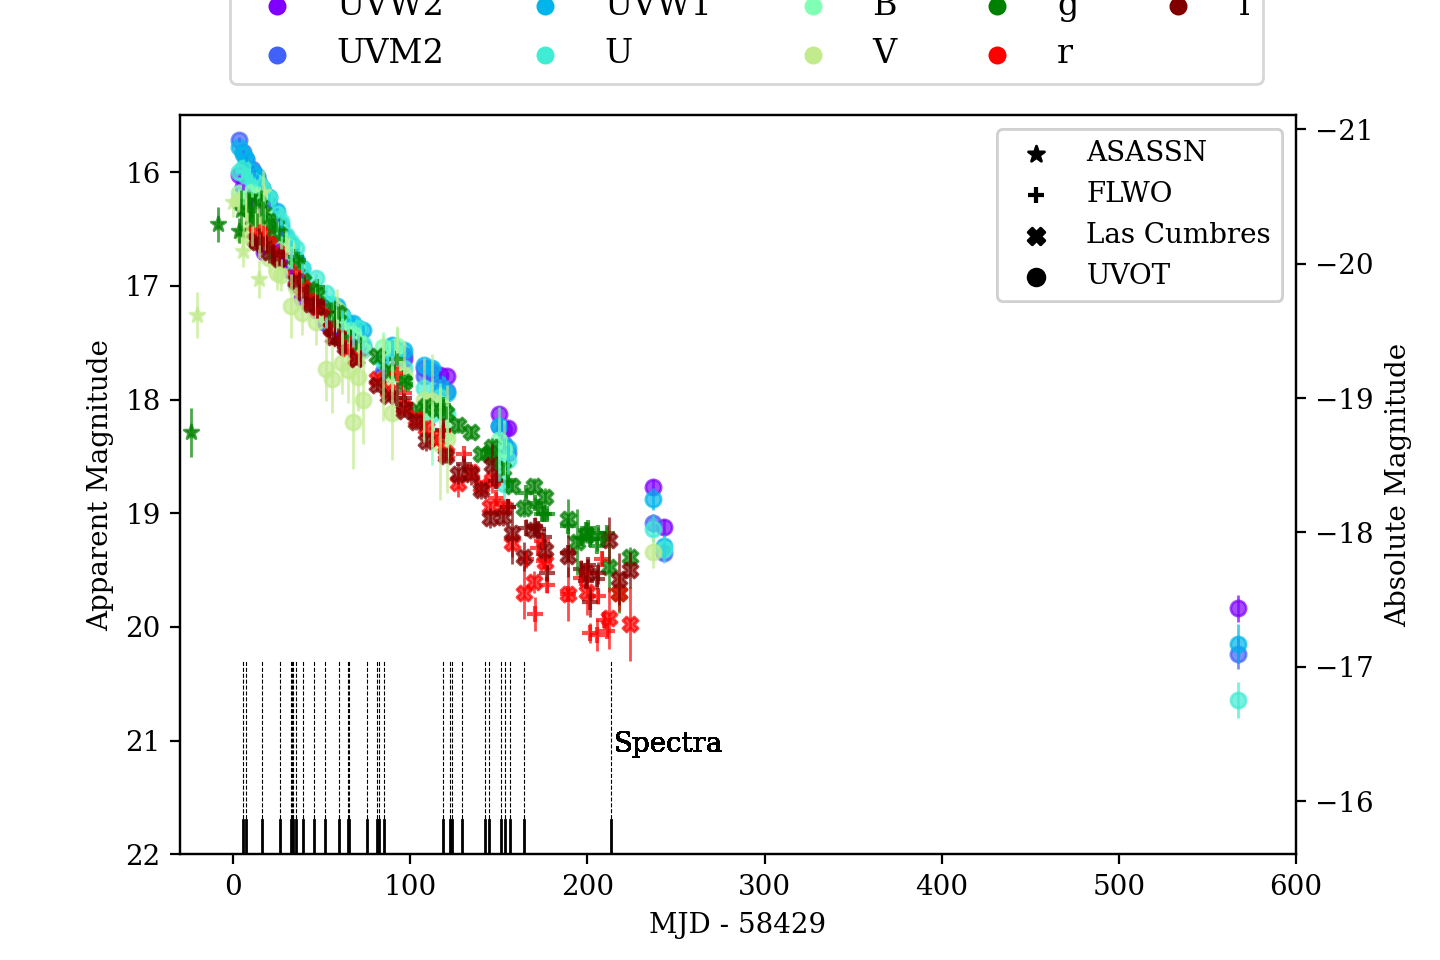

In [17]:
# Import Data
data_table = table.Table.read('Photometry.txt', format = 'ascii')

# Phase0
MJD0 = 58429
MJD  = data_table['MJD'] - MJD0

# Plot Colors
colors = cm.rainbow(np.linspace(0,1,9))
color_array = {'UVW2':colors[0],'UVM2':colors[1],'UVW1':colors[2],'U':colors[3],'B':colors[4],'V':colors[5],'g':'g','r':'r','i':'maroon'}
telescopes_array = {'ASASSN':'*','FLWO':'+','LCO':'X','UVOT':'o'}

# Plot Parameters
fig, ax1 = plt.subplots()
fig.set_size_inches(7.2, 4.8)
marker = 'o'
alpha  = 0.7
plt.gca().invert_yaxis()

# Plot Data
for band in color_array:
    match = data_table['Filter'] == band
    for telescope in telescopes_array:
        matchest = data_table['Telescope'][match] == telescope
        plt.errorbar(MJD[match][matchest], data_table['AB_Mag'][match][matchest], data_table['Error'][match][matchest], fmt    = telescopes_array[telescope], alpha = alpha,  ms = 0, linewidth = 1,   ecolor = color_array[band])
        plt.scatter (MJD[match][matchest], data_table['AB_Mag'][match][matchest],                                       marker = telescopes_array[telescope], alpha = alpha,  s = 30, linestyle = '-', color =  color_array[band])

# Make Legends
labels = []
for band in color_array:
    m = plt.scatter([], [], marker = 'o', s = 30, linestyle = '-', color = color_array[band], label = band)
    labels.append(m)
first_legend = plt.legend(handles=labels, ncol=5, bbox_to_anchor=(0.03, 1.02),loc='lower left', frameon = True, fontsize = 12)
ax0 = plt.gca().add_artist(first_legend)

labels2 = []
for telescope in telescopes_array:
    if telescope == 'LCO':
        label = 'Las Cumbres'
    else:
        label = telescope
    c = plt.scatter([], [], color = 'k', marker = telescopes_array[telescope], label = label)
    labels2.append(c)
second_legend = plt.legend(handles = labels2, loc='upper right', frameon = True, fontsize = 10)
ax2 = plt.gca().add_artist(second_legend)

# Plot Spectra Dates
spectra_dates = np.array([58434.553381,58436.513275,58445.54328,58455.5719709,58461.5,58462.45833333349,58462.6080688,58464.494016,58468.5841053,58474.5618892,58480.5937697,58488.6325732,58493.5923182,58494.375,58504.4132618,58510.375,58511.33333333349,58514.30477999989,58547.5063172,58551.29166666651,58552.29166666651,58558.2916169,58571.3207301,58573.2928195,58580.20055600023,58582.2427869,58585.069641000126,58593.2354472,58642.03144699987]) - MJD0

for i in spectra_dates:
    plt.plot([i, i], [22.0, 21.7], color = 'k', linewidth = 1.0)
    plt.plot([i, i], [22.0, 20.3], color = 'k', linewidth = 0.4, linestyle = '--')
    plt.annotate('Spectra', xy = (215, 21.1))

redshift = 0.04573
abs_mag_frame = ax1.twinx()
abs_mag_frame.set_ylim(redshift_magnitude(21.0, redshift)[0], redshift_magnitude(15.5, redshift)[0])
abs_mag_frame.set_ylabel('Absolute Magnitude')

ax1.set_xlim(-30, 600)
ax1.set_ylim(22.0, 15.5)
ax1.set_ylabel('Apparent Magnitude')
ax1.set_xlabel('MJD - %s'%MJD0);
#plt.savefig('lightcurve.pdf', bbox_inches = 'tight')

Light curve plot with X-ray data

<IPython.core.display.Javascript object>


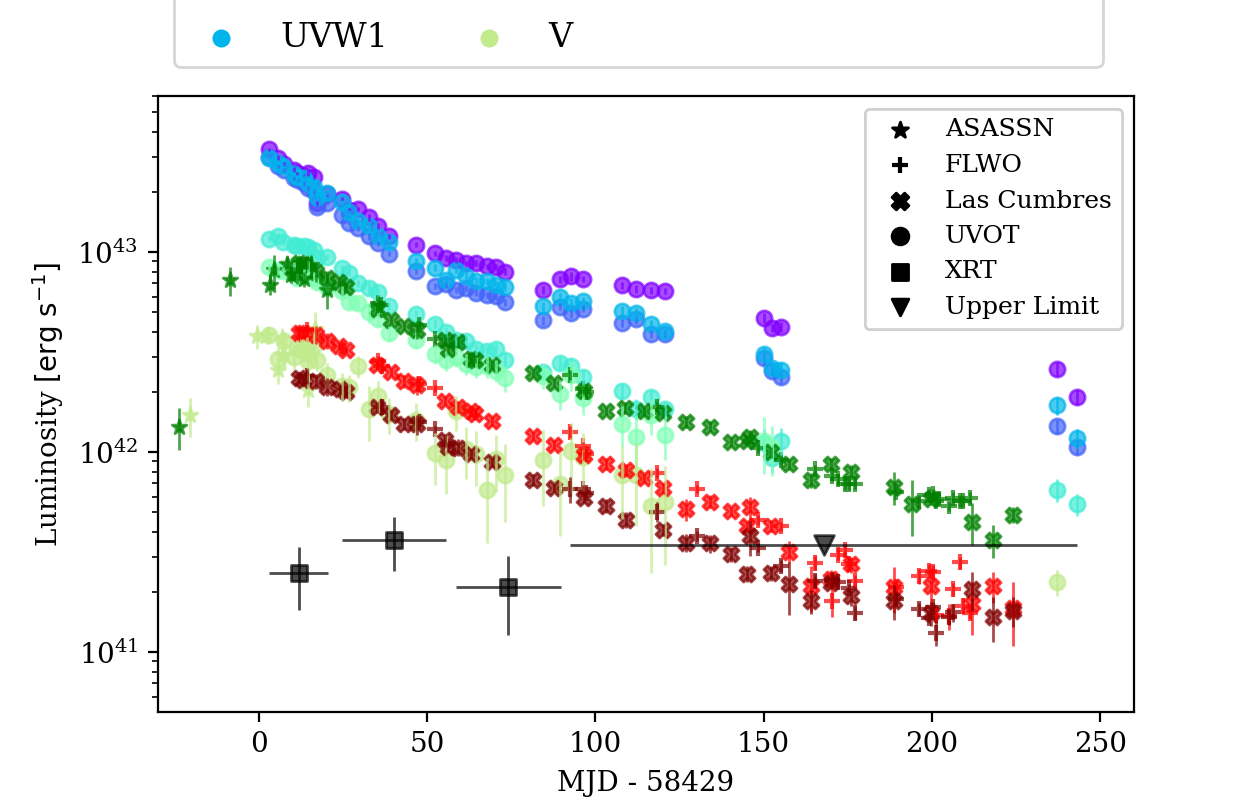

In [19]:
# Import X-ray Data
Xray = table.Table.read('XRT.txt', format = 'ascii')

# Distance
countratio = 6.16161e-11 # counts to erg/s/cm2
Dist_Mpc = 205
Distance_cm = Dist_Mpc * u.Mpc.to(u.cm)
norma = 4 * np.pi * Distance_cm ** 2
# Modify Data
Xray_MJD_center = 0.5 * (Xray['MJD_End'] + Xray['MJD_Start']) - MJD0
Xray_MJD_err    = 0.5 * (Xray['MJD_End'] - Xray['MJD_Start'])
Xray_flux       = Xray['Counts'] * countratio * norma
Xray_err        = Xray['Err'] * countratio * norma

# Get Flux from Optical Data
zeropoints ={'UVW2':2.502e-8,'UVM2':2.158e-8,'UVW1':1.511e-8,
             'U'   :8.781e-9,'B'   :5.763e-9,'V'   :3.717e-9,
             'g'   :4.773e-9,'r'   :2.897e-9,'i'   :1.943e-9}
widths     ={'UVW2':667.73  ,'UVM2':533.85  ,'UVW1':801.92  ,
             'U'   :662.50  ,'B'   :866.22  ,'V'   :655.67  ,
             'g'   :1158.37 ,'r'   :1111.18 ,'i'   :1044.55 }

Flux     = np.copy(data_table['AB_Mag'])
Flux_err = np.copy(data_table['Error'])

for band in zeropoints:
    match    = data_table['Filter'] == band
    Flux    [match] = np.array(10 ** (-0.4 * data_table[match]['AB_Mag']) * widths[band] * norma * zeropoints[band])
    Flux_err[match] = np.array(2.5/np.log(10) * Flux[match] * data_table[match]['Error'])

# Plot Xray Data
plt.figure(figsize = (6.3, 4))
plt.errorbar(Xray_MJD_center[:3], Xray_flux[:3], yerr = Xray_err[:3], xerr = Xray_MJD_err[:3], fmt = 's', alpha = alpha, ms = 0, linewidth = 1, ecolor = 'k')
plt.scatter (Xray_MJD_center[:3], Xray_flux[:3], marker = 's', alpha = alpha, s = 30, linestyle = '-', color = 'k')

plt.errorbar(Xray_MJD_center[3], Xray_flux[3], xerr = Xray_MJD_err[3], fmt = 's', alpha = alpha, ms = 0, linewidth = 1, ecolor = 'k', zorder = 50)
plt.scatter (Xray_MJD_center[3], Xray_flux[3], marker = 'v', alpha = alpha, s = 50, linestyle = '-', color = 'k', zorder = 50)

# Plot Optical Data
for band in color_array:
    match = data_table['Filter'] == band
    for telescope in telescopes_array:
        matchest = data_table['Telescope'][match] == telescope
        plt.errorbar(MJD[match][matchest], Flux[match][matchest], Flux_err[match][matchest], fmt    = telescopes_array[telescope], alpha = alpha,  ms = 0, linewidth = 1,   ecolor = color_array[band])
        plt.scatter (MJD[match][matchest], Flux[match][matchest],                            marker = telescopes_array[telescope], alpha = alpha,  s = 30, linestyle = '-', color =  color_array[band])

# Make Legends
labels = []
for band in color_array:
    m = plt.scatter([], [], marker = 'o', s = 30, linestyle = '-', color = color_array[band], label = band)
    labels.append(m)
labels.append(plt.scatter([], [], marker = 's', s = 30, color = 'k', label = '0.3-10keV'))
first_legend = plt.legend(handles=labels, ncol=4, bbox_to_anchor=(-0.00, 1.02),loc='lower left', frameon = True, fontsize = 12)
ax0 = plt.gca().add_artist(first_legend)

labels2 = []
for telescope in telescopes_array:
    if telescope == 'LCO':
        label = 'Las Cumbres'
    else:
        label = telescope
    c = plt.scatter([], [], color = 'k', marker = telescopes_array[telescope], label = label)
    labels2.append(c)
labels2.append(plt.scatter([], [], color = 'k', marker = 's', label = 'XRT'   ))
labels2.append(plt.scatter([], [], color = 'k', marker = 'v', label = 'Upper Limit'))
second_legend = plt.legend(handles = labels2, loc='upper right', frameon = True, fontsize = 9)
ax2 = plt.gca().add_artist(second_legend)

plt.xlim(-30, 260)
plt.yscale('log')
plt.ylim(1e-14 * norma, 1.2e-11 * norma)
plt.ylabel(r'Luminosity $[{\rm erg}\ {\rm s}^{-1}]$')
plt.xlabel('MJD - %s'%MJD0);
#plt.savefig('lightcurve_flux.pdf', bbox_inches = 'tight')
#plt.clf()


Plot with radio data

<IPython.core.display.Javascript object>


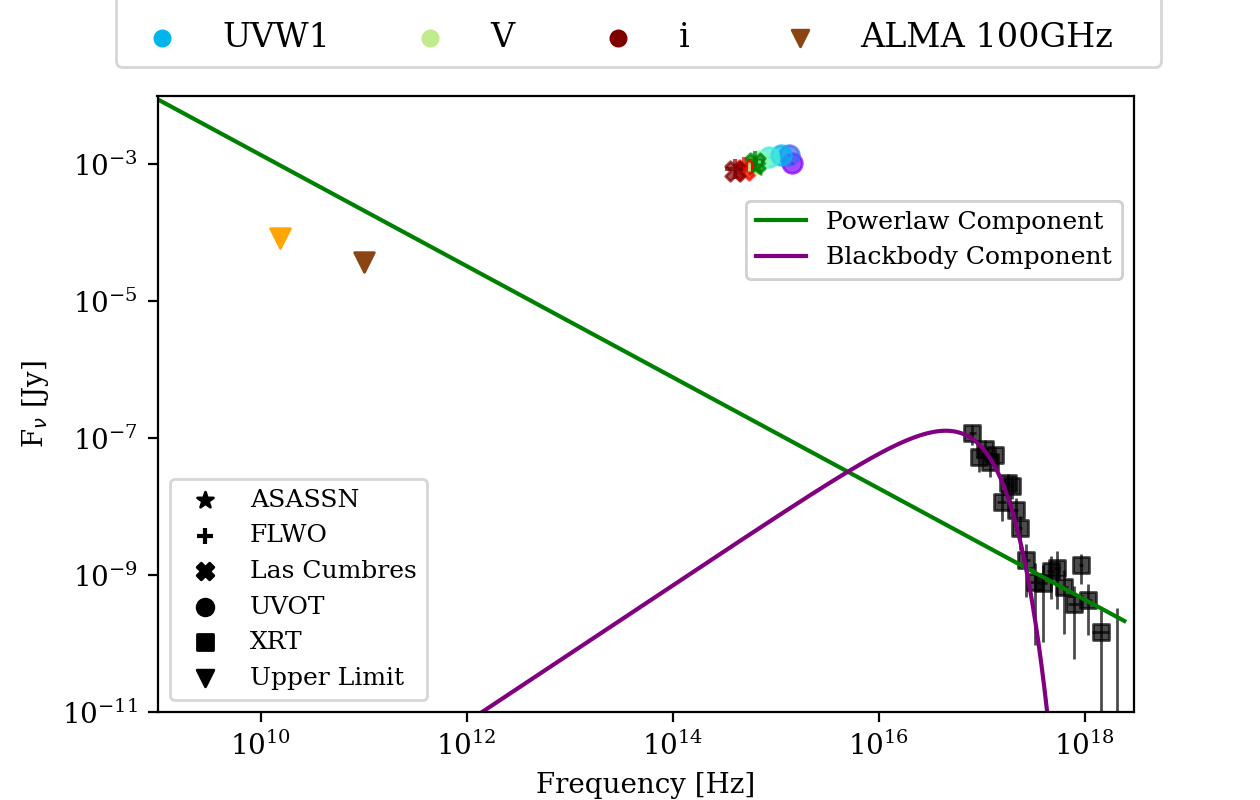

/Users/sebastian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice
/Users/sebastian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice


In [20]:
zp_jansky  ={'UVW2':3631.00,'UVM2':3631.00,'UVW1':3631.00,
             'U'   :3631.00,'B'   :3631.00,'V'   :3631.00,
             'g'   :3631.00,'r'   :3631.00,'i'   :3631.00}
wavelengths={'UVW2':2085.73,'UVM2':2245.78,'UVW1':2684.14,
             'U'   :3520.95,'B'   :4346.25,'V'   :5411.43,
             'g'   :4775.62,'r'   :6129.53,'i'   :7484.60}
wave_to_freq = 2.998E18

Flux_Jy     = np.copy(data_table['AB_Mag'])
Flux_Jy_err = np.copy(data_table['Error'])
frequencies = np.zeros(len(data_table['MJD']))

for band in zeropoints:
    match    = data_table['Filter'] == band
    Flux_Jy    [match] = np.array(10 ** (-0.4 * data_table[match]['AB_Mag']) * zp_jansky[band])
    Flux_Jy_err[match] = np.array(2.5/np.log(10) * Flux_Jy[match] * data_table[match]['Error'])
    frequencies[match] = wave_to_freq / wavelengths[band]

Early_Phase = MJD <= 25

# Plot Photometry
plt.figure(figsize = (6.3, 4))
for band in color_array:
    match = data_table[Early_Phase]['Filter'] == band
    for telescope in telescopes_array:
        matchest = data_table[Early_Phase]['Telescope'][match] == telescope
        plt.errorbar(np.nanmean(frequencies[Early_Phase][match][matchest]), np.nanmean(Flux_Jy[Early_Phase][match][matchest]), np.nanmean(Flux_Jy_err[Early_Phase][match][matchest]), fmt    = telescopes_array[telescope], alpha = alpha,  ms = 0, linewidth = 1,   ecolor = color_array[band])
        plt.scatter (np.nanmean(frequencies[Early_Phase][match][matchest]), np.nanmean(Flux_Jy[Early_Phase][match][matchest]),                                                        marker = telescopes_array[telescope], alpha = alpha,  s = 50, linestyle = '-', color =  color_array[band])


# Plot Radio
Radio_data = table.Table.read('Radio.txt', format = 'ascii')

# Upper Limit to Jy (from microJy)
Upper_Limit = 3 * Radio_data['RMS'] * 1E-6

# AMILA
plt.scatter(1E9 * Radio_data['Frequency'][0]  , Upper_Limit[0]  , marker = 'v', s = 50, linestyle = '-', color = 'orange'     , zorder = 50)
# ALMA
plt.scatter(1E9 * Radio_data['Frequency'][1:2], Upper_Limit[1:2], marker = 'v', s = 50, linestyle = '-', color = 'saddlebrown', zorder = 50)

# Plot Xray
Xray_data = table.Table.read('Xray.txt', format = 'ascii')

# Convert units
xray_Hz          = Xray_data['kev'] * 241.665E15
xray_Hz_err      = Xray_data['kev_err'] * 241.665E15
xray_flux_Jy     = Xray_data['flux'] / 1.50936 / 1000
xray_flux_err_Jy = Xray_data['flux_err'] / 1.50936 / 1000

# Convert units for model
xray_total_model_Jy = Xray_data['total_model'] / 1.50936 / 1000
xray_bb_model_Jy    = Xray_data['bb_model'] / 1.50936 / 1000
xray_pl_model_Jy    = Xray_data['pl_model'] / 1.50936 / 1000

# Create model
energies        = np.linspace(0.0000000001, 10, 100)
output_model    = 2.09672E-06 * energies ** (-0.812336)
output_model_up = 2.09672E-06 * energies ** (-0.812336+0.579273)
output_model_dn = 2.09672E-06 * energies ** (-0.812336-0.579273)
energies_Hz     = energies * 241.665E15
output_model_Jy = output_model / 1.50936 / 1000
output_model_Jy_up = output_model_up / 1.50936 / 1000
output_model_Jy_dn = output_model_dn / 1.50936 / 1000

# Blackbody Component
def blackbody(energy, dE, kT, norm):
   up = norm * 8.0525 * energy ** 2 #* dE
   down = kT ** 4 * (np.exp(energy / kT) - 1)
   return up / down

xray_line = np.linspace(0.000001, 10, 10000)
xray_line_Hz = xray_line * 241.665E15
output_blackbody = blackbody(xray_line, 0.1, 0.116081, 5.01891E-07)
output_blackbody_Jy = output_blackbody / 1.50936 / 1000

plt.errorbar(xray_Hz, xray_flux_Jy, yerr = xray_flux_err_Jy,    xerr = xray_Hz_err,    fmt    = 's', alpha = alpha,  ms = 0, linewidth = 1,   ecolor = 'k')
plt.scatter (xray_Hz, xray_flux_Jy, marker = 's', alpha = alpha,  s = 30, linestyle = '-', color =  'k')

plt.plot(energies_Hz, output_model_Jy, color = 'g')
plt.plot(xray_line_Hz, output_blackbody_Jy   , color = 'purple')

# Make Legends
labels = []
for band in color_array:
    m = plt.scatter([], [], marker = 'o', s = 30, linestyle = '-', color = color_array[band], label = band)
    labels.append(m)
labels.append(plt.scatter([], [], marker = 's', s = 30, color = 'k', label = '0.3-10keV'))
labels.append(plt.scatter([], [], color = 'orange'     , label = 'AMI-LA 15.5GHz', alpha = 1.0, marker = 'v'))
labels.append(plt.scatter([], [], color = 'saddlebrown', label = 'ALMA 100GHz'   , alpha = 1.0, marker = 'v'))
first_legend = plt.legend(handles=labels, ncol=4, bbox_to_anchor=(-0.06, 1.02),loc='lower left', frameon = True, fontsize = 12)
ax0 = plt.gca().add_artist(first_legend)

labels2 = []
for telescope in telescopes_array:
    if telescope == 'LCO':
        label = 'Las Cumbres'
    else:
        label = telescope
    c = plt.scatter([], [], color = 'k', marker = telescopes_array[telescope], label = label)
    labels2.append(c)
labels2.append(plt.scatter([], [], color = 'k', marker = 's', label = 'XRT'   ))
labels2.append(plt.scatter([], [], color = 'k', marker = 'v', label = 'Upper Limit'))
second_legend = plt.legend(handles = labels2, loc='lower left', frameon = True, fontsize = 9)
ax2 = plt.gca().add_artist(second_legend)

q1, = plt.plot([], [], color = 'g', label = 'Powerlaw Component')
q2, = plt.plot([], [], color = 'purple', label = 'Blackbody Component')
third_legend = plt.legend(handles=[q1, q2], loc='upper right', frameon = True, fontsize = 9, bbox_to_anchor=(1, 0.85))
ax3 = plt.gca().add_artist(third_legend)

plt.ylim(1E-11, 1E-2)
plt.xlim(1E9, 3E18)
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'F$_\nu$ [Jy]')
plt.xlabel('Frequency [Hz]');
#plt.savefig('powerlaw.pdf', bbox_inches = 'tight')
#plt.clf()

SED with X-ray model

<IPython.core.display.Javascript object>


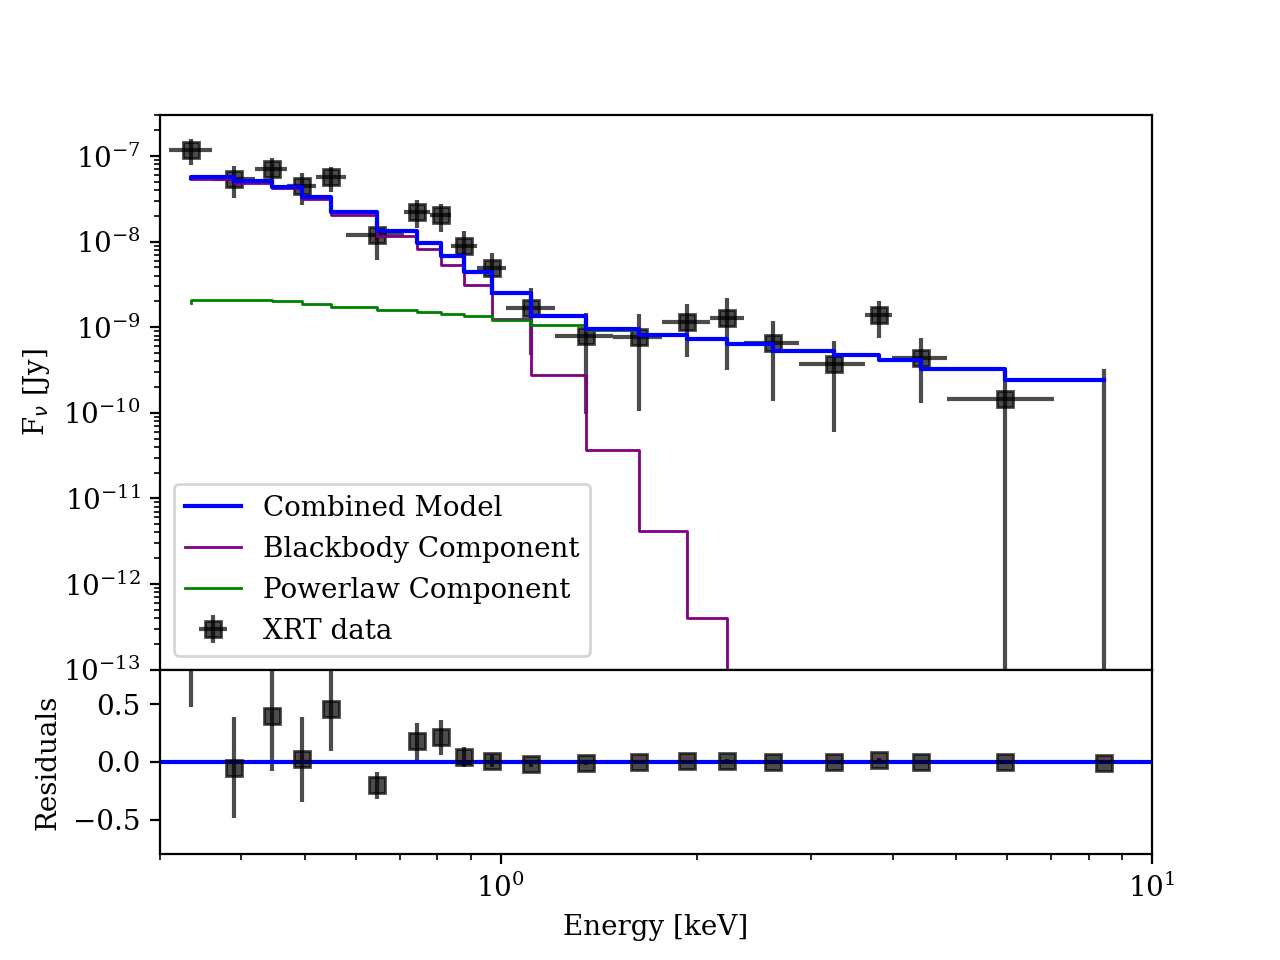

In [23]:
plt.close('all')
plt.subplots_adjust(hspace=0)
gs  = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
ax0 = plt.subplot(gs[0])
plt.tick_params(axis='both', bottom=False, labelbottom=False)
ax0.set_yscale('log')
ax0.set_xscale('log')
ax0.errorbar(Xray_data['kev'], xray_flux_Jy, yerr = xray_flux_err_Jy, xerr = Xray_data['kev_err'], fmt = 's', color = 'k', label = 'XRT data', alpha = 0.7)
ax0.step(Xray_data['kev']    , xray_total_model_Jy, color = 'b', label = 'Combined Model', zorder = 10)
ax0.step(Xray_data['kev']    , xray_bb_model_Jy, color = 'purple', label = 'Blackbody Component', zorder = 8, linewidth = 1)
ax0.step(Xray_data['kev']    , xray_pl_model_Jy, color = 'g', label = 'Powerlaw Component', zorder = 8, linewidth = 1)
ax0.legend(loc = 'lower left')
plt.ylabel(r'F$_\nu$ [Jy]')
ax0.set_xlim(0.3, 10.0)
ax0.set_ylim(10E-14, 3E-7)

norm = 5E-8
ax1 = plt.subplot(gs[1])
ax1.set_xlabel('Energy [keV]')
ax1.set_ylabel('Residuals')
ax1.set_xscale('log')
ax1.axhline(0, color='b')
ax1.errorbar(Xray_data['kev'], (xray_flux_Jy / norm) - (xray_total_model_Jy / norm), yerr = xray_flux_err_Jy / norm, fmt = 's', color = 'k', alpha = 0.7)
ax1.set_ylim(-0.8, 0.8)
ax1.set_xlim(0.3, 10.0);

#plt.savefig('xray.pdf', bbox_inches = 'tight')
#plt.clf()




Plot of MOSFiT Model

<IPython.core.display.Javascript object>


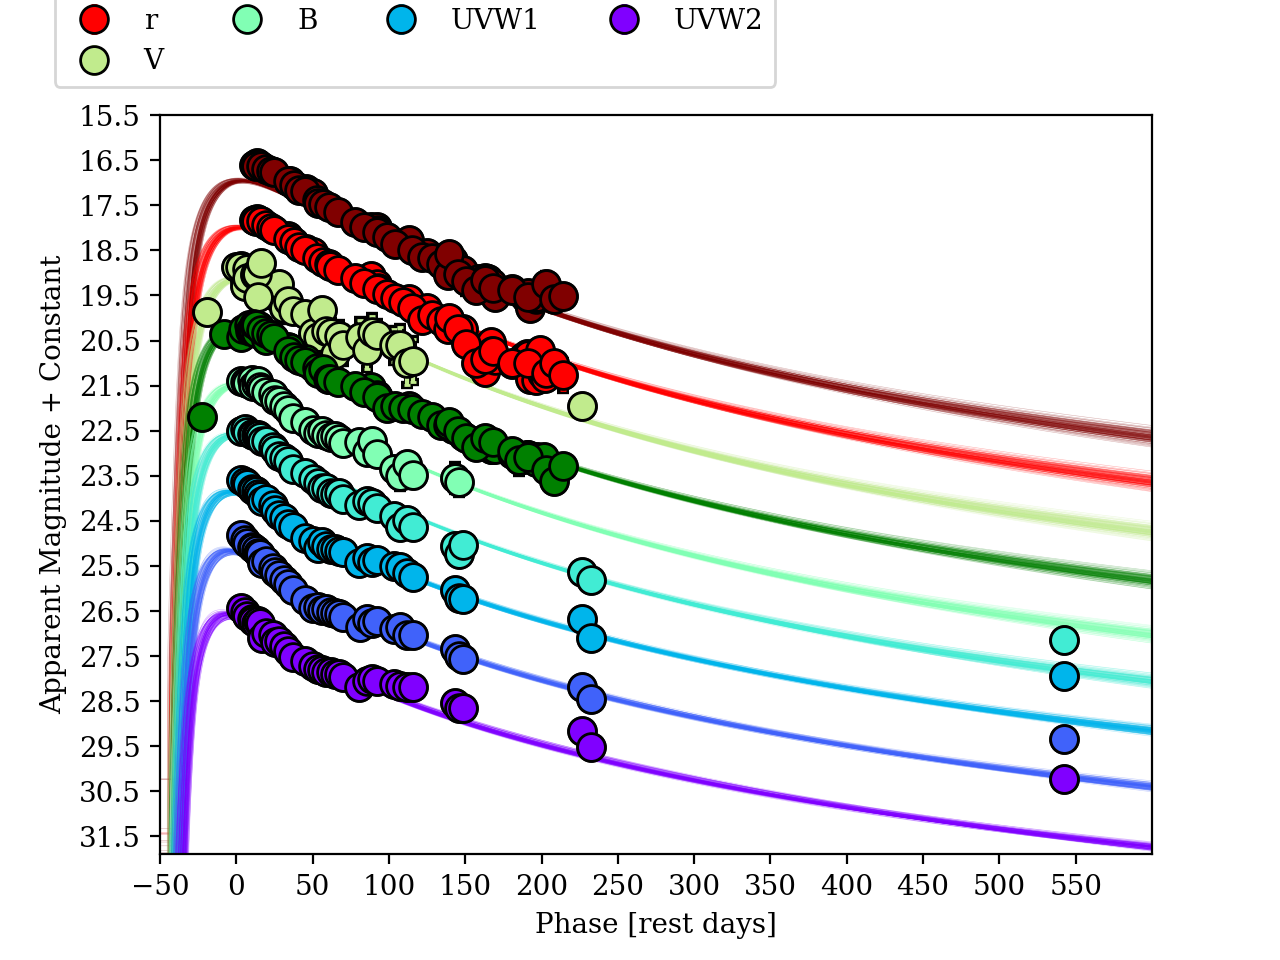

In [24]:
# Import Model
model_MJD = np.genfromtxt('models/MJD.txt')

UVM2_Model = np.genfromtxt('models/UVM2_Mag.txt')
B_Model    = np.genfromtxt('models/B_Mag.txt')
g_Model    = np.genfromtxt('models/g_Mag.txt')
i_Model    = np.genfromtxt('models/i_Mag.txt')
r_Model    = np.genfromtxt('models/r_Mag.txt')
U_Model    = np.genfromtxt('models/U_Mag.txt')
UVW1_Model = np.genfromtxt('models/UVW1_Mag.txt')
UVW2_Model = np.genfromtxt('models/UVW2_Mag.txt')
V_Model    = np.genfromtxt('models/V_Mag.txt')

# Phase
MJD0 = 58429
redshift = 0.045726
Phase = (model_MJD - MJD0) / (1 + redshift)

# Import Data
data_table = table.Table.read('Photometry.txt', format = 'ascii')

# Band Offsets and Colors
offsets = np.arange(0, 1.3 * 9, 1.3) 
colors = cm.rainbow(np.linspace(0,1,9))
color_array = {'i':'maroon','r':'r','V':colors[5],'g':'g','B':colors[4],'U':colors[3],'UVW1':colors[2],'UVM2':colors[1],'UVW2':colors[0]}

# Plot
plt.gca().invert_yaxis()
plt.gca().set_xlim(-50, 600)
#plt.gca().set_ylim(bottom=25, top=17)
plt.gca().set_ylim(bottom=31.9, top=15.5)
plt.gca().set_xticks(np.arange(-50, 600, 50))
plt.gca().set_yticks(np.arange(15.5, 31.9, 1))
plt.gca().set_xlabel('Phase [rest days]')
plt.gca().set_ylabel('Apparent Magnitude + Constant')

plt.plot(Phase, i_Model    + offsets[0], color = 'maroon' , alpha=0.3, linewidth=0.2)
plt.plot(Phase, r_Model    + offsets[1], color = 'r'      , alpha=0.3, linewidth=0.2)
plt.plot(Phase, V_Model    + offsets[2], color = colors[5], alpha=0.3, linewidth=0.2)
plt.plot(Phase, g_Model    + offsets[3], color = 'g'      , alpha=0.3, linewidth=0.2)
plt.plot(Phase, B_Model    + offsets[4], color = colors[4], alpha=0.3, linewidth=0.2)
plt.plot(Phase, U_Model    + offsets[5], color = colors[3], alpha=0.3, linewidth=0.2)
plt.plot(Phase, UVW1_Model + offsets[6], color = colors[2], alpha=0.3, linewidth=0.2)
plt.plot(Phase, UVM2_Model + offsets[7], color = colors[1], alpha=0.3, linewidth=0.2)
plt.plot(Phase, UVW2_Model + offsets[8], color = colors[0], alpha=0.3, linewidth=0.2)

# Plot Data
for i, band in enumerate(color_array):
    match = data_table['Filter'] == band
    plt.errorbar((data_table['MJD'][match]- MJD0) / (1 + redshift), data_table['AB_Mag'][match]+offsets[i], yerr=data_table['Error'][match], color=color_array[band], fmt='o', label = band,
                 markeredgecolor='black', markeredgewidth=1, capsize=1,elinewidth=1.5, capthick=2, zorder=10, ms = 10)
    plt.errorbar((data_table['MJD'][match]- MJD0) / (1 + redshift), data_table['AB_Mag'][match]+offsets[i], yerr=data_table['Error'][match], color='k', fmt='o', capsize=2,
                 elinewidth=2.5, capthick=3, zorder=5, ms = 10)

plt.legend(ncol=4, bbox_to_anchor=(-0.12, 1.02),loc='lower left', frameon = True);
#plt.savefig('lc_mosfit.pdf', bbox_inches = 'tight')
#plt.clf()


Plot of bolometric light curve

<IPython.core.display.Javascript object>


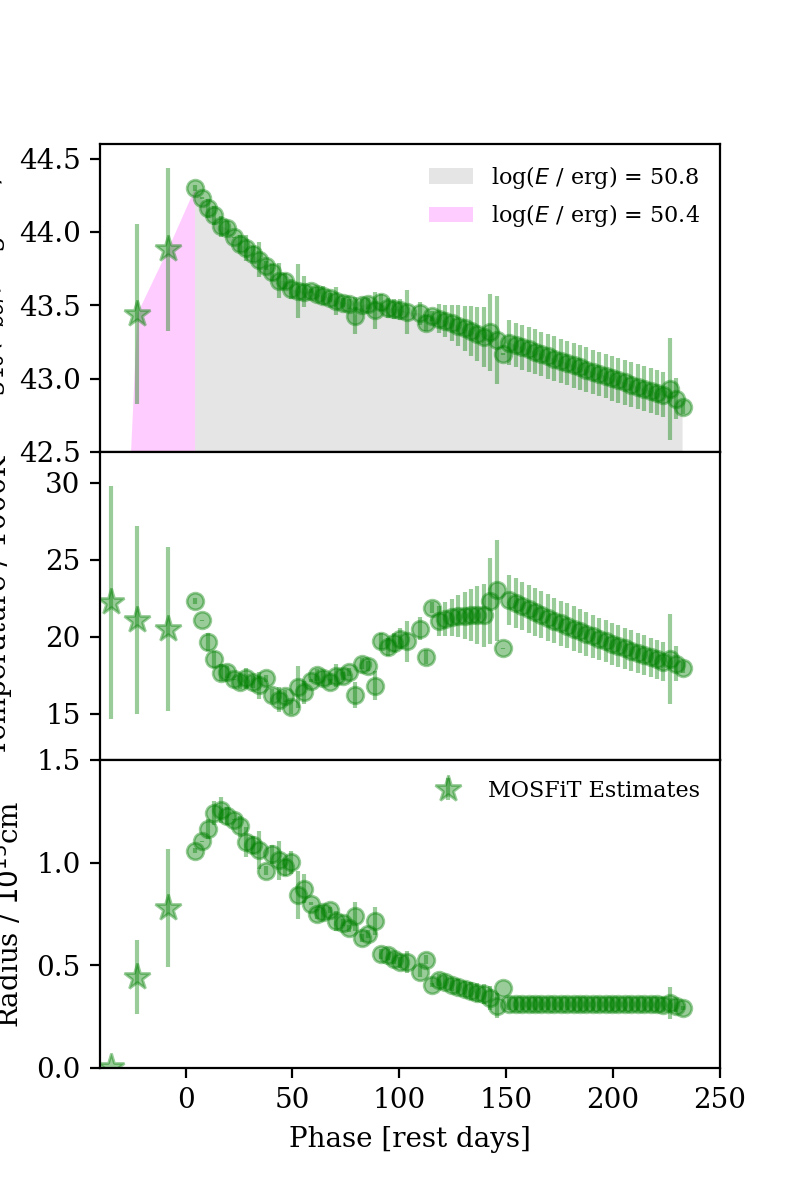

In [25]:
# Import Data
phase, lum, lum_error, temp, temp_error, radius, rad_error = np.genfromtxt('Bolometric.txt', unpack = True)
data = phase > 0

# Integrate Luminosity
total_lum=np.log10(itg.trapz(lum[data],phase[data]*3600*24))
total_lum_model=np.log10(itg.trapz(lum[:4],phase[:4]*3600*24))

# Plot Bolometric Lightcurve
plt.figure(figsize=(4,6))
plt.subplots_adjust(hspace=0)
plt.subplot(311)
plt.xlim(-40, 250)
plt.ylim(42.5, 44.6)
plt.errorbar(phase[data], np.log10(lum[data]), yerr = 1/np.log(10) * lum_error[data] / lum[data], fmt = 'o', color = 'g', alpha = 0.4)
plt.fill_between(phase[data], 0, np.log10(lum[data]), color = 'gray', alpha = 0.2, label = r'log($E$ / erg) = %s'%np.around(total_lum, 1), linewidth = 0)
plt.errorbar(phase[:3], np.log10(lum[:3]), yerr = 1/np.log(10) * lum_error[:3] / lum[:3], fmt = '*', color = 'g', alpha = 0.4, ms = 10)
plt.fill_between(phase[:4], 0, np.log10(lum[:4]), color = 'magenta', alpha = 0.2, label = r'log($E$ / erg) = %s'%np.around(total_lum_model, 1), linewidth = 0)
plt.legend(loc = 'upper right', frameon = False, fontsize = 8)
plt.xlabel('Rest days from bolometric maximum')
plt.ylabel(r'log$_{10} (\mathit{L}_{bol}\,/$erg$\,s^{-1})$')
plt.tick_params(axis='both', bottom=False, labelbottom=False)

# Plot Temperature
plt.subplot(312)
plt.xlim(-40, 250)
plt.ylim(12, 32)
plt.errorbar(phase[data], temp[data] / 1000, temp_error[data] / 1000, fmt = 'o', color = 'g', alpha = 0.4)
plt.errorbar(phase[~data], temp[~data] / 1000, temp_error[~data] / 1000, fmt = '*', color = 'g', alpha = 0.4, ms = 10)
plt.ylabel('Temperature / 1000K', labelpad = 12)
plt.tick_params(axis='both', bottom=False, labelbottom=False)

# Plot Radius
plt.subplot(313)
plt.xlim(-40, 250)
plt.ylim(0.0, 1.5)
plt.errorbar(phase[data],  radius[data] / 1E15, rad_error[data] / 1E15, fmt = 'o', color = 'g', alpha = 0.4)
plt.errorbar(phase[~data], radius[~data] / 1E15, rad_error[~data] / 1E15, fmt = '*', color = 'g', alpha = 0.4, label = 'MOSFiT Estimates', ms = 10)
plt.legend(loc = 'upper right', frameon = False, fontsize = 8)
plt.ylabel(r'Radius / $10^{15}$cm')
plt.xlabel('Phase [rest days]');
#plt.savefig("Bolometric.pdf", bbox_inches = 'tight')
#plt.clf(); plt.close('all')
